In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File importing 

Customize which analysis you want to do

## Parameters:

- model: micro, uno
- milliseconds: 10 (only micro), 50, 100, 150, 200 ms
- distance: 10, 30, 50 cm
- light: True, False

In [2]:
model = "one"
millis = 100
light = False
distance = 10

data_path = "data/"

if light == False:
    light = "_d"
else:
    light = ""
    

file_path = data_path + "arduino_" + model + \
       "/opt_s" + str(distance) + "_t" + str(millis) + light + ".log"

print(file_path)

data/arduino_one/opt_s10_t100_d.log


In [3]:
n_lines = 10
with open(file_path, 'r') as f:
    cnt = 0
    output = ""
    while cnt < n_lines:
        output += f.readline()
        cnt+=1
        
print(output)

; 1.00
30516; 1.00
30530; 1.00
30543; 1.00
30557; 1.00
30570; 1.00
30583; 1.00
30598; 1.00
0; 4.00
0; 4.00



# Show the data

In [4]:
# first rows are artefacts, skipping them
skiprows=20
df = pd.read_csv(file_path, sep=';', header=None, skiprows=skiprows)
df.columns = ['t', 'y']
                    
df.head(2)

,t,y
0,48,4.0
1,58,4.0


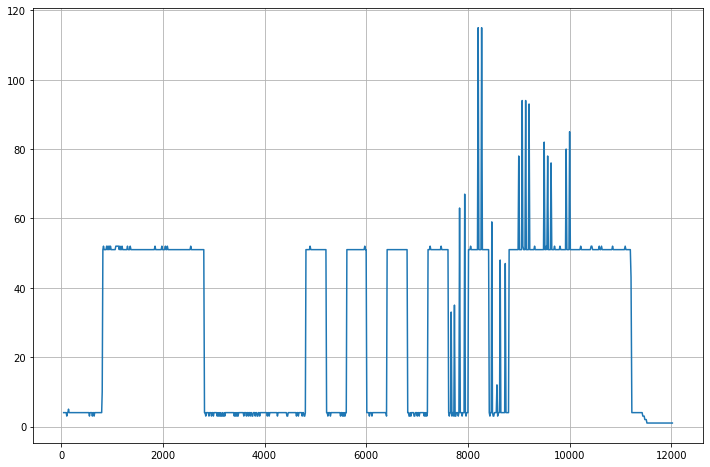

In [5]:
fig = plt.figure(figsize=(12,8))
plt.plot(df.t, df.y)
plt.grid()
plt.show()

# Simulating the receiving algorithm

In [6]:
import numpy as np

rest_state = True
configuration_state = False
loiter_state = False
receiving_state = False
conclusion_state = False

zero_setting_time = df["t"][0] + 1000
zero_list = df[df["t"] <= zero_setting_time]
nominal_zero = np.mean(zero_list)["y"]
zero_thr = 2*nominal_zero

df_real_time = df[df["t"] > zero_setting_time]
df_real_time.reset_index(inplace = True)
ratio = 0.5
cumulative_mean = nominal_zero
loiter_t = 2000
signal_delta = millis

message = ""
final_message = ""

debug = True

for i in range(0, len(df_real_time)):
    
    y = df_real_time["y"][i]
    t = df_real_time["t"][i]
    
    if rest_state:
        if debug: print("rest state", y, t)
        if y > zero_thr:
            thr = zero_thr
            configuration_state = True
            rest_state = False

    if configuration_state:
        if debug: print("configuration state", y, t, thr, cumulative_mean)
        if y < thr:
            loiter_state = True
            configuration_state = False
            loiter_start = t
        if configuration_state:
            cumulative_mean = (y + cumulative_mean)/2
            thr = cumulative_mean*ratio
        
    if loiter_state:
        if debug: print("loiter state", y, t)
        if t >= loiter_start + loiter_t:
            loiter_state = False
            receiving_state = True
            t_0 = t
            cnt = 1
            n_peaks = 0
            n_gaps = 0
    
    if receiving_state:
        if debug: print("receiving state", y, t, t_0)
        if y >= thr:
            n_peaks += 1
        else:
            n_gaps += 1
        if t >= t_0 + cnt*signal_delta:
            #print(n_peaks, n_gaps, t)
            cnt += 1
            if n_peaks >= n_gaps:
                message = message + "1"
            else:
                if message[-10:] == "1111111111" or message[-10:] == "0000000000":
                    message = message[:-10]
                    receiving_state = False
                    conclusion_state = True
                    break
                message = message + "0"
            n_peaks = 0
            n_gaps = 0
    
if conclusion_state:
    print("conclusion state", y, t)
    for idx in range(len(message)//4):
        n1 = 0; n0 = 0
        for bit in message[idx*4:(idx+1)*4]:
            if bit == "1":
                n1 += 1
            else:
                n0 += 1
        if n1 >= n0:
            final_message = final_message + "1"
        else:
            final_message = final_message + "0"
            
    rest_state = True

rest state 51.0 1061
configuration state 51.0 1061 28.71264367816092 14.35632183908046
configuration state 52.0 1075 16.339080459770116 32.67816091954023
configuration state 52.0 1088 21.169540229885058 42.339080459770116
configuration state 52.0 1101 23.58477011494253 47.16954022988506
configuration state 52.0 1116 24.792385057471265 49.58477011494253
configuration state 52.0 1129 25.396192528735632 50.792385057471265
configuration state 51.0 1142 25.698096264367816 51.39619252873563
configuration state 52.0 1156 25.59904813218391 51.19809626436782
configuration state 51.0 1169 25.799524066091955 51.59904813218391
configuration state 51.0 1183 25.649762033045977 51.299524066091955
configuration state 52.0 1197 25.574881016522987 51.149762033045974
configuration state 51.0 1210 25.787440508261493 51.57488101652299
configuration state 51.0 1223 25.64372025413075 51.2874405082615
configuration state 51.0 1236 25.571860127065374 51.14372025413075
configuration state 51.0 1251 25.535930063

loiter state 4.0 4391
loiter state 4.0 4404
loiter state 4.0 4416
loiter state 4.0 4428
loiter state 3.0 4442
loiter state 3.0 4454
loiter state 4.0 4466
loiter state 4.0 4478
loiter state 4.0 4491
loiter state 4.0 4504
loiter state 4.0 4516
loiter state 4.0 4529
loiter state 4.0 4541
loiter state 4.0 4553
loiter state 4.0 4566
loiter state 4.0 4579
loiter state 4.0 4591
loiter state 4.0 4603
loiter state 4.0 4616
loiter state 3.0 4628
loiter state 4.0 4641
loiter state 4.0 4654
loiter state 3.0 4666
loiter state 4.0 4678
loiter state 4.0 4690
loiter state 4.0 4704
loiter state 4.0 4716
loiter state 4.0 4728
loiter state 3.0 4741
loiter state 4.0 4753
loiter state 4.0 4765
loiter state 3.0 4779
loiter state 3.0 4791
loiter state 4.0 4803
loiter state 51.0 4815
loiter state 51.0 4829
receiving state 51.0 4829 4829
receiving state 51.0 4843 4829
receiving state 51.0 4856 4829
receiving state 51.0 4870 4829
receiving state 51.0 4883 4829
receiving state 52.0 4896 4829
receiving state 51.0

receiving state 4.0 8446 4829
receiving state 4.0 8459 4829
receiving state 59.0 8471 4829
receiving state 4.0 8484 4829
receiving state 3.0 8498 4829
receiving state 3.0 8510 4829
receiving state 4.0 8522 4829
receiving state 4.0 8535 4829
receiving state 4.0 8547 4829
receiving state 4.0 8559 4829
receiving state 12.0 8572 4829
receiving state 3.0 8586 4829
receiving state 4.0 8598 4829
receiving state 4.0 8610 4829
receiving state 4.0 8623 4829
receiving state 48.0 8636 4829
receiving state 4.0 8649 4829
receiving state 4.0 8662 4829
receiving state 4.0 8674 4829
receiving state 4.0 8686 4829
receiving state 4.0 8699 4829
receiving state 4.0 8712 4829
receiving state 4.0 8724 4829
receiving state 47.0 8736 4829
receiving state 4.0 8750 4829
receiving state 4.0 8763 4829
receiving state 4.0 8775 4829
receiving state 4.0 8787 4829
receiving state 4.0 8800 4829
receiving state 51.0 8812 4829
receiving state 51.0 8825 4829
receiving state 51.0 8840 4829
receiving state 51.0 8853 4829
re

In [7]:
# original
print("11110000111100001111000011110000111100001111")
print(message)

11110000111100001111000011110000111100001111
111100001111000011110000111100001111000011111111111111


In [8]:
print("10101010101")
print(final_message)

10101010101
1010101010111


## Create result folder

In [9]:
import os
from Levenshtein import distance as levenshtein_distance
create_result = False
output_path = ('data/results.csv')

original_message = "10101010101"

In [10]:
path ="data/"

filelist = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file[-3:] == "log":
            filelist.append(os.path.join(root,file))

In [11]:
def hamming_distance(original, predicted):
    if len(original) != len(predicted):
        return float('NaN')
    else:
        x1 = np.array([int(x) for x in original])
        x2 = np.array([int(x) for x in predicted])
        
        return np.sum(x1 != x2)

In [12]:
def offline_results(df, millis, verbose=False):
    rest_state = True
    configuration_state = False
    loiter_state = False
    receiving_state = False
    conclusion_state = False

    zero_setting_time = df["t"][0] + 1000
    zero_list = df[df["t"] <= zero_setting_time]
    nominal_zero = np.mean(zero_list)["y"]
    zero_thr = 2*nominal_zero

    df_real_time = df[df["t"] > zero_setting_time]
    df_real_time.reset_index(inplace = True)
    ratio = 0.5
    cumulative_mean = nominal_zero
    loiter_t = 2000
    signal_delta = millis

    message = ""
    final_message = ""

    debug = False
    
    for i in range(0, len(df_real_time)):

        y = df_real_time["y"][i]
        t = df_real_time["t"][i]

        if rest_state:
            if debug: print("rest state", y, t)
            if y > zero_thr:
                thr = zero_thr
                configuration_state = True
                rest_state = False

        if configuration_state:
            if debug: print("configuration state", y, t, thr, cumulative_mean)
            if y < thr:
                loiter_state = True
                configuration_state = False
                loiter_start = t
            if configuration_state:
                cumulative_mean = (y + cumulative_mean)/2
                thr = cumulative_mean*ratio

        if loiter_state:
            if debug: print("loiter state", y, t)
            if t >= loiter_start + loiter_t:
                loiter_state = False
                receiving_state = True
                t_0 = t
                cnt = 1
                n_peaks = 0
                n_gaps = 0

        if receiving_state:
            if debug: print("receiving state", y, t, t_0)
            if y >= thr:
                n_peaks += 1
            else:
                n_gaps += 1
            if t >= t_0 + cnt*signal_delta:
                #print(n_peaks, n_gaps, t)
                cnt += 1
                if n_peaks >= n_gaps:
                    message = message + "1"
                else:
                    if message[-10:] == "1111111111" or message[-10:] == "0000000000":
                        message = message[:-10]
                        receiving_state = False
                        conclusion_state = True
                        break
                    message = message + "0"
                n_peaks = 0
                n_gaps = 0

    if conclusion_state:
        if verbose==True: print("conclusion state", y, t)
        for idx in range(len(message)//4):
            n1 = 0; n0 = 0
            for bit in message[idx*4:(idx+1)*4]:
                if bit == "1":
                    n1 += 1
                else:
                    n0 += 1
            if n1 >= n0:
                final_message = final_message + "1"
            else:
                final_message = final_message + "0"

        rest_state = True
        
    return message, final_message

In [13]:
def get_info(file):
    
    model = file.split('/')[1].split('_')[1]
    distance = int(file.split('/')[2].split('_')[1].split('s')[1])
    
    # if there is no d
    if len(file.split('/')[2].split('_')) == 4:
        # in the darkness
        light = False
        
        # take delta_t 
        millis = file.split('/')[2].split('_')[2].split('t')[1].split('.')[0]
    else:
        # in the light
        light = True
        
        # take millis
        millis = file.split('/')[2].split('_')[2].split('t')[1].split('.')[0]
        
    millis = int(millis)
    
    return model, distance, millis, light

In [14]:
if create_result:
    res = []
    
    for file in filelist:
        
        model, distance, millis, light = get_info(file)
        skiprows=20

        try:
            df = pd.read_csv(file, sep=';', header=None, skiprows=skiprows)
            df.columns = ['t', 'y']
            message, final_message = offline_results(df, millis, verbose=False)
            
            res.append([file.split('/')[2], model, 
                        distance, millis, light,
                        message, str(final_message)])
        except:
            print('error in file <{}>'.format(file))
            
        
    df = pd.DataFrame(res)
    df.columns = ['file', 'model', 'cm', 'ms', 'light', 'message', 'final_message']
    df['LD'] = df['final_message'].apply(lambda x: levenshtein_distance(original_message, x))

    df.to_csv(output_path, index=False)

error in file <data/arduino_micro/opt_s50_t200_d.log>
error in file <data/arduino_micro/opt_s30_t200.log>
error in file <data/arduino_micro/opt_s10_t50.log>
error in file <data/arduino_one/opt_s30_t200_d.log>
error in file <data/arduino_one/opt_s30_t100.log>


In [21]:
pd.read_csv(output_path)

,file,model,cm,ms,light,message,final_message,LD
0,opt_s30_t200_d.log,micro,30,200,False,11110000111100001111000011110000111100001111,10101010101,0
1,opt_s50_t50.log,micro,50,50,True,111111111111111111111111111111,1111111,5
2,opt_s50_t100_d.log,micro,50,100,False,1111000011110000111100001111000011110000111111...,1010101010111,2
3,opt_s10_t200.log,micro,10,200,True,11110000111100001111000011110000111100001111,10101010101,0
4,opt_s50_t50_d.log,micro,50,50,False,1111000011110000111100001111000011110000111111...,101010101011111111,7
5,opt_s30_t150.log,micro,30,150,True,11110000111100001111000011110000111100001111111,10101010101,0
6,opt_s10_t10.log,micro,10,10,True,1111000011110000111100001111000011110000111111...,1010101010111111111111111111111111111111111111...,47
7,opt_s30_t100_d.log,micro,30,100,False,1111000011110000111100001111000011110000111111...,1010101010111,2
8,opt_s10_t100.log,micro,10,100,True,1111000011110000111100001111000011110000111111...,1010101010111,2
9,opt_s50_t150.log,micro,50,150,True,111100001111000011110000111100001111000011111111,101010101011,1
